In [1]:
# qualify on member status active only:

In [2]:
# import numpy and pandas
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import datasets
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import metrics

# used for dates
import datetime
from datetime import datetime, date

# Set some pandas options controlling output format
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 8)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 90)

# bring in matplotlib for graphics
import matplotlib.pyplot as plt
%matplotlib inline

### upload .png files

In [3]:
br = '\n'
# upload files

df = np.load('data/df.npy')
df_features = np.load('data/features.npy')

In [4]:
print(df_features)

['Household_Key' 'Individual_Key' 'City' 'State_Grouped' 'ZIP5' 'ZIP9'
 'FSV_CMSI_Flag' 'FSV_Credit_Card_Flag' 'FSV_Deposit_Program_Flag'
 'FSV_Home_Equity_Flag' 'FSV_ID_Theft_Flag' 'FSV_Mortgage_Flag'
 'INS_Client_Flag' 'TRV_Globalware_Flag' 'Number_of_Children'
 'Responded_to_Catalog' 'Race' 'Length_Of_Residence' 'Mail_Responder'
 'Home_Owner' 'Income' 'Date_Of_Birth' 'Age' 'Children' 'Education'
 'Dwelling_Type' 'Credit_Ranges' 'Language' 'Gender' 'Branch_Name'
 'County' 'Join_AAA_Date' 'Member_Phone_Type' 'Member_Status'
 'Member_Tenure_Years' 'Member_Type' 'Reinstate_Date' 'Renew_Method' 'ZIP'
 'Mosaic_Household' 'Mosaic_Global_Household' 'kcl_B_IND_MosaicsGrouping'
 'New_Mover_Flag' 'Occupation_Code' 'Occupation_Group'
 'Right_Dwelling_Type' 'Move_Distance' 'Occupant_Type' 'Membership_Level'
 'Roadside_Service' '_memeber_count' '_service_cnt' '_total_cost'
 '_total_products' '_ERS_ENT_Count_Year_1' '_ERS_ENT_Count_Year_2'
 '_ERS_ENT_Count_Year_3' '_ERS_Member_Cost_Year_1'
 '_ERS_

In [5]:
dfv = pd.DataFrame(df, columns=df_features)
dfv.head()

  Household_Key Individual_Key      City State_Grouped           ...            \
0           875         717785  CRANSTON            RI           ...             
1           969          19943  JOHNSTON            RI           ...             
2          8718         199385  CRANSTON            RI           ...             
3         11524       52285851  JOHNSTON            RI           ...             
4         13422      170834500  COVENTRY            RI           ...             

  _ERS_ENT_Count_Year_3 _ERS_Member_Cost_Year_1 _ERS_Member_Cost_Year_2  \
0                     9                  2118.6                  2118.6   
1                    27                       0                  940.85   
2                     0                       0                       0   
3                     1                       0                       0   
4                     0                   58.85                       0   

  _ERS_Member_Cost_Year_3  
0                 3197.57  


In [6]:
dfv['Member_Status'].unique()
df_temp = dfv[dfv['Member_Status'] == 'ACTIVE'].copy()

In [7]:
# # select the columns from above data
# li =  ['Home_Owner', 'Age', 'Length_Of_Residence', 'Member_Tenure_Years', 
#        'New_Mover_Flag', 'Education', 'Dwelling_Type', '_total_products']
# li


In [8]:
li = ['Home_Owner', 'Age', 'Length_Of_Residence', \
      'Credit_Ranges', 'Education', '_total_products']
li

['Home_Owner',
 'Age',
 'Length_Of_Residence',
 'Credit_Ranges',
 'Education',
 '_total_products']

In [9]:
df1= df_temp[li].copy()
df2 = df1.dropna()
subdf = df2.drop_duplicates()
print("subset df shape:", subdf.shape, " orignal df shape:", df.shape )


subset df shape: (1935, 6)  orignal df shape: (3219, 60)


In [10]:
# percentile list 
perc =[.20, .40, .60, .80] 
# list of dtypes to include 
include =['object', 'float', 'int'] 
desc = subdf.describe(percentiles = perc, include = include) 
print(desc.iloc[:,0:5])
print("--"*50)
print(desc.iloc[:,6:11])


        Home_Owner   Age  Length_Of_Residence Credit_Ranges     Education
count         1935  1935                 1935          1935          1935
unique           4    71                   35             9             5
top     Home.Owner    75                   15       750-799  Some.College
freq          1850   209                  845           641           558
----------------------------------------------------------------------------------------------------
Empty DataFrame
Columns: []
Index: [count, unique, top, freq]


# X,y

In [11]:
def yes_or_no(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return np.NaN  

In [12]:
# data_X
select_col = li[:-1]
print(select_col)
print("--"*50)
y_col = li[-1]
print("target y:", y_col)

#split the dataset to X & y:
X = subdf.drop([y_col], axis=1).values
fix_y = subdf[y_col].apply(yes_or_no)
#fix_y = subdf[y_col].copy()
print("max y:", fix_y.max())
y = fix_y.values
print("y is", y)

# data_X contains only X
data_X = subdf[select_col].copy()
print(data_X.head())

['Home_Owner', 'Age', 'Length_Of_Residence', 'Credit_Ranges', 'Education']
----------------------------------------------------------------------------------------------------
target y: _total_products
max y: 1
y is [0 1 1 ... 0 0 1]
   Home_Owner Age Length_Of_Residence Credit_Ranges         Education
1  Home.Owner  77                  15          800+       High.School
2  Home.Owner  68                  15          800+      Some.College
3  Home.Owner  76                  15       700-749       High.School
4  Home.Owner  70                  15       650-699  Graduated.School
5  Home.Owner  95                  15       700-749       High.School


### Machine Learning algorithms only operate on numberical data

In [13]:
subdf[select_col].iloc[50]

Home_Owner              Home.Owner
Age                             85
Length_Of_Residence             13
Credit_Ranges              750-799
Education              High.School
Name: 72, dtype: object

### Encoding

In [14]:
# columns numbers only 
#data_X['Member_Tenure_Years'].astype(int)
cat_vars = ['Home_Owner', 'Education', 'Credit_Ranges']
print("selected columns:", cat_vars)

data_new = pd.get_dummies(data_X, columns=cat_vars)
data_new.columns
#print("features: \n", list(data_new))

selected columns: ['Home_Owner', 'Education', 'Credit_Ranges']


Index(['Age', 'Length_Of_Residence', 'Home_Owner_Home.Owner',
       'Home_Owner_Probable.Home.Owner', 'Home_Owner_Probable.Renter',
       'Home_Owner_Renter', 'Education_Completed.College', 'Education_Graduated.School',
       'Education_High.School', 'Education_Some.College', 'Education_Unknown',
       'Credit_Ranges_499.Less', 'Credit_Ranges_500-549', 'Credit_Ranges_550-599',
       'Credit_Ranges_600-649', 'Credit_Ranges_650-699', 'Credit_Ranges_700-749',
       'Credit_Ranges_750-799', 'Credit_Ranges_800+', 'Credit_Ranges_Unknown'],
      dtype='object')

In [15]:
X = data_new
y = y
print(X.shape, y.shape)
print("--"*50)
attributes = list(data_X)
print("X attributes: \n", attributes)
print("--"*50)
print(X.head())

(1935, 20) (1935,)
----------------------------------------------------------------------------------------------------
X attributes: 
 ['Home_Owner', 'Age', 'Length_Of_Residence', 'Credit_Ranges', 'Education']
----------------------------------------------------------------------------------------------------
  Age Length_Of_Residence  Home_Owner_Home.Owner  Home_Owner_Probable.Home.Owner  \
1  77                  15                      1                               0   
2  68                  15                      1                               0   
3  76                  15                      1                               0   
4  70                  15                      1                               0   
5  95                  15                      1                               0   

           ...            Credit_Ranges_700-749  Credit_Ranges_750-799  \
1          ...                                0                      0   
2          ...                     

In [16]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=0,n_estimators=100)
# Train the classifier
rf.fit(X,y)
# Print the name and gini importance of each feature
feat_labels = attributes
feat_list=[]
for feature in zip(feat_labels, rf.feature_importances_):
    feat_list.append(feature)

feat_list.sort(key=lambda x:x[1], reverse=True) #To sort by first element of the tuple   
ds = pd.DataFrame(feat_list)
ds.columns =[['cols','imp']]
ds

                  cols       imp
0           Home_Owner  0.555169
1                  Age  0.284630
2  Length_Of_Residence  0.008061
3        Credit_Ranges  0.000359
4            Education  0.000269

In [17]:
cols=list(ds['cols'])
cols.reverse()

imp=list(ds['imp'])
imp.reverse()

cols

[('cols',)]

In [18]:
fields = []
importance = []
cols = ds['cols'].copy()
imp = ds['imp'].copy()

l = ds.shape[0]
for r in range(l):
    c =(cols.iloc[r].values).tolist()
    i =(imp.iloc[r].values.astype(str)).tolist()
    
    # convert list to string
    strc = ''.join(c)
    stri = ''.join(i)    

    fields.append(strc)
    importance.append(float(stri))
    
print("columns:", fields)
print("Importance", importance)

columns: ['Home_Owner', 'Age', 'Length_Of_Residence', 'Credit_Ranges', 'Education']
Importance [0.5551688458033536, 0.284629531283792, 0.008060889829071992, 0.00035895090721720584, 0.00026910496165423247]


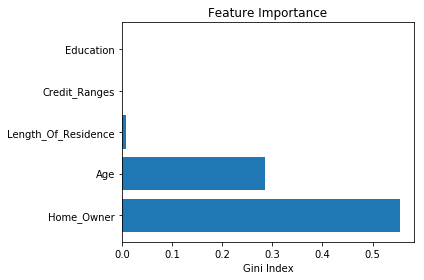

In [19]:

plt.barh(fields, importance)

plt.title("Feature Importance")
# plt.ylabel("Programming Languages")
plt.xlabel("Gini Index")

plt.tight_layout()

plt.show()


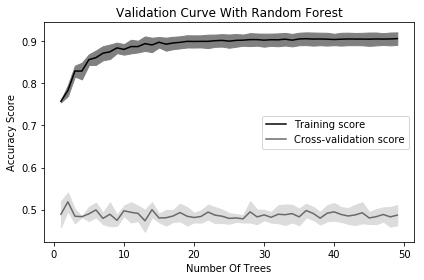

Train Mean: 0.889440891818445
Test Mean: 0.4872693816522734


In [20]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve


# Create range of values for parameter
param_range = np.arange(1, 50, 1)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X, 
                                             y, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)



# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

print("Train Mean:", train_mean.mean())
print("Test Mean:", test_mean.mean())